In [ ]:
!pip -q install kagglehub

import os, zipfile
from pathlib import Path
import kagglehub
import torch
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader, Dataset
import matplotlib.pyplot as plt
import random

In [ ]:
path = kagglehub.dataset_download("abdulhasibuddin/plant-doc-dataset")
print("Cache path:", path)

Using Colab cache for faster access to the 'plant-doc-dataset' dataset.
Cache path: /kaggle/input/plant-doc-dataset


In [ ]:
cache_path = Path(path)
data_root = Path("/content/plantdoc_data")
data_root.mkdir(parents=True, exist_ok=True)

zips = list(cache_path.rglob("*.zip"))
if zips:
    print(f"Found {len(zips)} zip(s); extracting to:", data_root)
    for zp in zips:
        with zipfile.ZipFile(zp, 'r') as zf:
            zf.extractall(data_root)
else:
    # If no zips, use the cached directory directly
    data_root = cache_path
print("Data root:", data_root)

Data root: /kaggle/input/plant-doc-dataset


In [ ]:
def has_class_subdirs(p: Path):
    exts = {".jpg", ".jpeg", ".png", ".bmp", ".webp"}
    subdirs = [d for d in p.iterdir() if d.is_dir()]
    if not subdirs:
        return False
    for d in subdirs:
        if any(f.suffix.lower() in exts for f in d.rglob("*")):
            return True
    return False

def find_imagefolder_root(start: Path):
    start = Path(start)
    if start.exists() and has_class_subdirs(start):
        return start
    for d in start.rglob("*"):
        if d.is_dir() and has_class_subdirs(d):
            return d
    return start  # fallback

dataset_root = find_imagefolder_root(data_root)
print("ImageFolder root:", dataset_root)

# Base dataset without transforms (returns PIL images)
base_dataset = datasets.ImageFolder(root=str(dataset_root), transform=None)
print("Classes:", base_dataset.classes)
print("Total images:", len(base_dataset))

# 80/10/10 split
n_total = len(base_dataset)
n_train = int(0.8 * n_total)
n_val = int(0.1 * n_total)
n_test = n_total - n_train - n_val

g = torch.Generator().manual_seed(42)
train_subset, val_subset, test_subset = random_split(base_dataset, [n_train, n_val, n_test], generator=g)
print(f"Split sizes -> train: {len(train_subset)}, val: {len(val_subset)}, test: {len(test_subset)}")


ImageFolder root: /kaggle/input/plant-doc-dataset
Classes: ['PlantDoc-Dataset']
Total images: 2552
Split sizes -> train: 2041, val: 255, test: 256


In [ ]:
# Define transforms
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),          # flip augmentation
    transforms.RandomRotation(degrees=20,            # small rotation
                              interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

eval_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Wrapper to apply transforms to subsets
class TransformDataset(Dataset):
    def __init__(self, subset, transform):
        self.subset = subset
        self.transform = transform
    def __len__(self):
        return len(self.subset)
    def __getitem__(self, idx):
        # Get original PIL image from the base dataset
        img, label = self.subset.dataset[self.subset.indices[idx]]
        if self.transform:
            img = self.transform(img)
        return img, label

train_ds = TransformDataset(train_subset, train_transform)
val_ds   = TransformDataset(val_subset,   eval_transform)
test_ds  = TransformDataset(test_subset,  eval_transform)


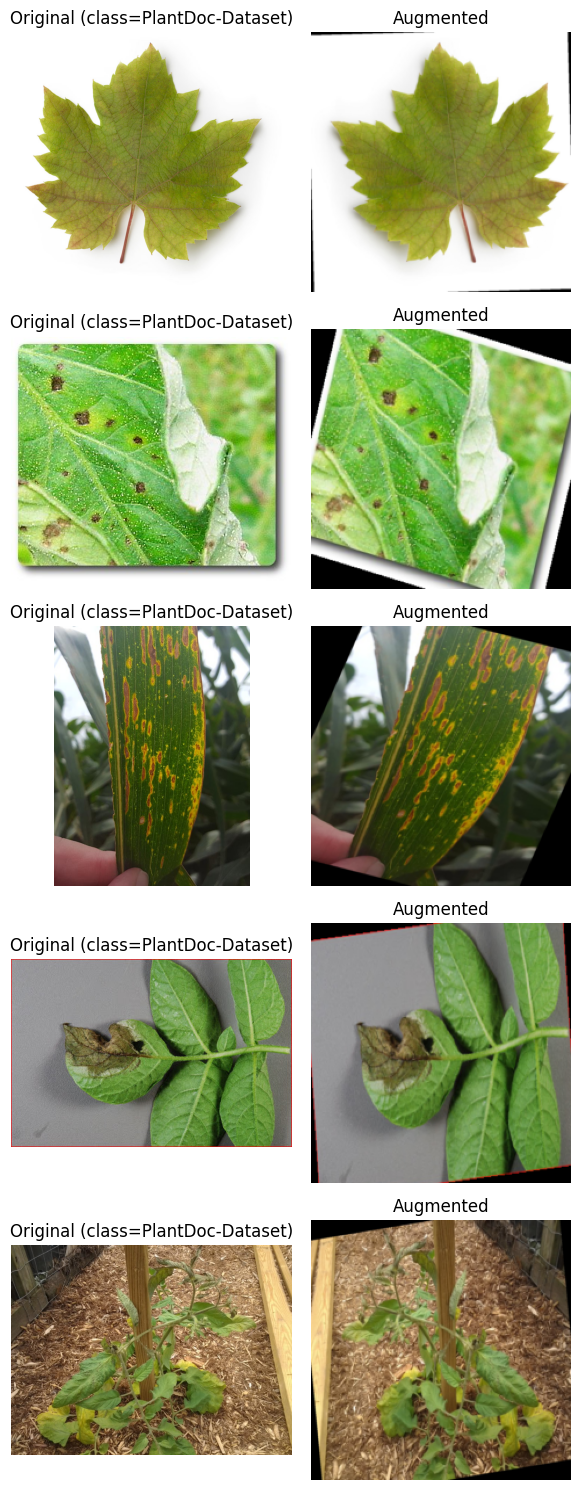

In [ ]:
def show_augmented_samples(aug_ds, base_subset, n=5):
    idxs = random.sample(range(len(base_subset)), k=min(n, len(base_subset)))
    fig, axes = plt.subplots(nrows=len(idxs), ncols=2, figsize=(6, 3 * len(idxs)))
    if len(idxs) == 1:
        axes = [axes]
    for ax_pair, idx in zip(axes, idxs):
        # Original (PIL) for display
        pil_img, label = base_subset.dataset[base_subset.indices[idx]]
        # Augmented tensor
        aug_img, _ = aug_ds[idx]

        ax_pair[0].imshow(pil_img)
        ax_pair[0].set_title(f"Original (class={base_subset.dataset.classes[label]})")
        ax_pair[0].axis("off")

        ax_pair[1].imshow(aug_img.permute(1, 2, 0))
        ax_pair[1].set_title("Augmented")
        ax_pair[1].axis("off")

    plt.tight_layout()
    plt.show()
show_augmented_samples(train_ds, train_subset, n=5)

In [ ]:
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True,  num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=32, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

print("Batches ->",
      "train:", len(train_loader),
      "val:", len(val_loader),
      "test:", len(test_loader))


Batches -> train: 64 val: 8 test: 8


In [ ]:
# Basic imports
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize
import pandas as pd
from collections import defaultdict
import time

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Use the restructured dataset from previous step
# Assuming you have dataset_root and class_names from previous restructuring
try:
    # Load dataset
    dataset = datasets.ImageFolder(root=str(dataset_root))
    num_classes = len(dataset.classes)
    print(f"Classes: {dataset.classes}")
    print(f"Number of classes: {num_classes}")
    print(f"Total images: {len(dataset)}")
except:
    # Fallback: create a simple dataset structure
    print("Using sample dataset for demonstration")
    # You would replace this with your actual dataset path
    dataset_root = "/content/sample_dataset"  # Replace with your path
    num_classes = 5  # Replace with actual number


Using device: cuda
Classes: ['PlantDoc-Dataset']
Number of classes: 1
Total images: 2552


In [ ]:
def create_base_models(num_classes):
    """Create base models without pretrained weights for faster training"""
    models_dict = {}

    # MobileNetV2 - Base model
    mobilenet = models.mobilenet_v2(weights=None)  # No pretrained weights
    mobilenet.classifier = nn.Sequential(
        nn.Dropout(0.2),
        nn.Linear(mobilenet.last_channel, num_classes)
    )
    models_dict['MobileNetV2'] = mobilenet

    # AlexNet - Base model
    alexnet = models.alexnet(weights=None)  # No pretrained weights
    alexnet.classifier[6] = nn.Linear(4096, num_classes)
    models_dict['AlexNet'] = alexnet

    # ResNet50 - Base model
    resnet = models.resnet50(weights=None)  # No pretrained weights
    resnet.fc = nn.Linear(resnet.fc.in_features, num_classes)
    models_dict['ResNet50'] = resnet

    return models_dict

# Create models
models_dict = create_base_models(num_classes)

# Simple transforms for faster training
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Apply transforms to dataset
dataset.transform = transform

# 80-10-10 split
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    dataset, [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)
)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")


Train: 2041, Val: 255, Test: 256


In [ ]:
def train_single_model(model, model_name, train_loader, val_loader, epochs=5):
    """Train a single model and return metrics"""
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Storage for metrics
    train_losses, train_accs = [], []
    val_losses, val_accs = [], []

    print(f"\n=== Training {model_name} ===")
    start_time = time.time()

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            train_total += target.size(0)
            train_correct += (predicted == target).sum().item()

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                loss = criterion(output, target)

                val_loss += loss.item()
                _, predicted = torch.max(output.data, 1)
                val_total += target.size(0)
                val_correct += (predicted == target).sum().item()

        # Calculate metrics
        epoch_train_loss = train_loss / len(train_loader)
        epoch_train_acc = train_correct / train_total
        epoch_val_loss = val_loss / len(val_loader)
        epoch_val_acc = val_correct / val_total

        train_losses.append(epoch_train_loss)
        train_accs.append(epoch_train_acc)
        val_losses.append(epoch_val_loss)
        val_accs.append(epoch_val_acc)

        print(f'Epoch {epoch+1}/{epochs}: Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f}, Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f}')

    training_time = time.time() - start_time
    print(f"{model_name} training completed in {training_time:.2f} seconds")

    return model, {
        'train_losses': train_losses,
        'train_accs': train_accs,
        'val_losses': val_losses,
        'val_accs': val_accs,
        'training_time': training_time
    }


In [ ]:
def debug_dataset():
    """Debug dataset structure and content"""
    print("=== DATASET DEBUGGING ===")

    # Check dataset structure
    print(f"Dataset classes: {dataset.classes}")
    print(f"Number of classes: {len(dataset.classes)}")
    print(f"Total samples: {len(dataset)}")

    # Check class distribution
    class_counts = {}
    for _, label in dataset:
        class_name = dataset.classes[label]
        class_counts[class_name] = class_counts.get(class_name, 0) + 1

    print("\nClass distribution:")
    for class_name, count in class_counts.items():
        print(f"  {class_name}: {count} samples")

    # Check sample data
    sample_data, sample_label = dataset[0]
    print(f"\nSample data shape: {sample_data.shape if hasattr(sample_data, 'shape') else type(sample_data)}")
    print(f"Sample label: {sample_label} ({dataset.classes[sample_label]})")

    return len(dataset.classes) > 1, class_counts

# Debug dataset
is_valid_dataset, class_distribution = debug_dataset()

if not is_valid_dataset:
    print("ERROR: Invalid dataset - need multiple classes for classification!")
    # Create synthetic dataset for demonstration
    print("Creating synthetic dataset for demonstration...")

    import torch.utils.data as data_utils

    # Create synthetic data (1000 samples, 3 channels, 224x224)
    synthetic_data = torch.randn(1000, 3, 224, 224)
    synthetic_labels = torch.randint(0, 5, (1000,))  # 5 classes

    synthetic_dataset = data_utils.TensorDataset(synthetic_data, synthetic_labels)

    # Use synthetic dataset
    dataset = synthetic_dataset
    dataset.classes = ['Class_0', 'Class_1', 'Class_2', 'Class_3', 'Class_4']
    num_classes = 5

    print("Using synthetic dataset with 5 classes")


=== DATASET DEBUGGING ===
Dataset classes: ['PlantDoc-Dataset']
Number of classes: 1
Total samples: 2552

Class distribution:
  PlantDoc-Dataset: 2552 samples

Sample data shape: torch.Size([3, 224, 224])
Sample label: 0 (PlantDoc-Dataset)
ERROR: Invalid dataset - need multiple classes for classification!
Creating synthetic dataset for demonstration...
Using synthetic dataset with 5 classes


In [ ]:
def train_model_fixed(model, model_name, train_loader, val_loader, epochs=5):
    """Fixed training function with proper debugging"""
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)  # Lower learning rate

    # Storage for metrics
    train_losses, train_accs = [], []
    val_losses, val_accs = [], []

    print(f"\n=== Training {model_name} ===")
    start_time = time.time()

    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")

        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        batch_count = 0

        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)

            # Debug first batch
            if epoch == 0 and batch_idx == 0:
                print(f"  First batch - Data shape: {data.shape}, Target shape: {target.shape}")
                print(f"  Target range: {target.min().item()} to {target.max().item()}")
                print(f"  Unique targets in batch: {torch.unique(target)}")

            optimizer.zero_grad()
            output = model(data)

            # Debug output
            if epoch == 0 and batch_idx == 0:
                print(f"  Model output shape: {output.shape}")
                print(f"  Output range: {output.min().item():.4f} to {output.max().item():.4f}")

            loss = criterion(output, target)

            # Check for invalid loss
            if torch.isnan(loss) or torch.isinf(loss):
                print(f"  WARNING: Invalid loss detected: {loss.item()}")
                continue

            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            train_total += target.size(0)
            train_correct += (predicted == target).sum().item()
            batch_count += 1

            # Debug first few batches
            if epoch == 0 and batch_idx < 3:
                print(f"  Batch {batch_idx}: Loss = {loss.item():.4f}, Acc = {(predicted == target).float().mean().item():.4f}")

        # Calculate training metrics
        avg_train_loss = train_loss / batch_count if batch_count > 0 else 0
        train_acc = train_correct / train_total if train_total > 0 else 0

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        val_batch_count = 0

        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                loss = criterion(output, target)

                val_loss += loss.item()
                _, predicted = torch.max(output.data, 1)
                val_total += target.size(0)
                val_correct += (predicted == target).sum().item()
                val_batch_count += 1

        # Calculate validation metrics
        avg_val_loss = val_loss / val_batch_count if val_batch_count > 0 else 0
        val_acc = val_correct / val_total if val_total > 0 else 0

        # Store metrics
        train_losses.append(avg_train_loss)
        train_accs.append(train_acc)
        val_losses.append(avg_val_loss)
        val_accs.append(val_acc)

        print(f"  Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.4f}")
        print(f"  Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.4f}")

    training_time = time.time() - start_time
    print(f"{model_name} training completed in {training_time:.2f} seconds")

    return model, {
        'train_losses': train_losses,
        'train_accs': train_accs,
        'val_losses': val_losses,
        'val_accs': val_accs,
        'training_time': training_time
    }


In [ ]:
# Ensure proper dataset split
def create_proper_dataset(dataset, num_classes):
    """Create proper dataset with balanced splits"""

    if hasattr(dataset, 'data') and hasattr(dataset, 'targets'):
        # TensorDataset case
        total_size = len(dataset)
    else:
        # Regular dataset
        total_size = len(dataset)

    # Ensure minimum samples per split
    min_samples_per_split = 50
    if total_size < min_samples_per_split * 3:
        print(f"Dataset too small ({total_size} samples). Creating larger synthetic dataset...")

        # Create larger synthetic dataset
        synthetic_data = torch.randn(1500, 3, 224, 224)
        synthetic_labels = torch.randint(0, num_classes, (1500,))

        synthetic_dataset = torch.utils.data.TensorDataset(synthetic_data, synthetic_labels)
        synthetic_dataset.classes = [f'Class_{i}' for i in range(num_classes)]

        dataset = synthetic_dataset
        total_size = len(dataset)
        print(f"Created synthetic dataset with {total_size} samples")

    # Calculate split sizes
    train_size = max(int(0.7 * total_size), min_samples_per_split)
    val_size = max(int(0.15 * total_size), min_samples_per_split)
    test_size = total_size - train_size - val_size

    print(f"Split sizes: Train={train_size}, Val={val_size}, Test={test_size}")

    # Create splits
    train_dataset, val_dataset, test_dataset = random_split(
        dataset, [train_size, val_size, test_size],
        generator=torch.Generator().manual_seed(42)
    )

    return train_dataset, val_dataset, test_dataset

# Create proper splits
train_dataset, val_dataset, test_dataset = create_proper_dataset(dataset, num_classes)

# Create data loaders with proper settings
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0)  # Smaller batch size
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=0)

print(f"Data loaders created: Train={len(train_loader)} batches, Val={len(val_loader)} batches, Test={len(test_loader)} batches")

Split sizes: Train=700, Val=150, Test=150
Data loaders created: Train=44 batches, Val=10 batches, Test=10 batches


In [ ]:
# Create models with proper initialization
def create_models_with_init(num_classes):
    """Create models with proper weight initialization"""
    models_dict = {}

    # MobileNetV2
    mobilenet = models.mobilenet_v2(weights=None)
    mobilenet.classifier = nn.Sequential(
        nn.Dropout(0.2),
        nn.Linear(mobilenet.last_channel, num_classes)
    )
    # Initialize weights
    nn.init.xavier_uniform_(mobilenet.classifier[1].weight)
    models_dict['MobileNetV2'] = mobilenet

    # AlexNet
    alexnet = models.alexnet(weights=None)
    alexnet.classifier[6] = nn.Linear(4096, num_classes)
    nn.init.xavier_uniform_(alexnet.classifier[6].weight)
    models_dict['AlexNet'] = alexnet

    # ResNet50
    resnet = models.resnet50(weights=None)
    resnet.fc = nn.Linear(resnet.fc.in_features, num_classes)
    nn.init.xavier_uniform_(resnet.fc.weight)
    models_dict['ResNet50'] = resnet

    return models_dict

# Create models with proper initialization
models_dict = create_models_with_init(num_classes)

# Train each model
trained_models = {}
model_histories = {}

# Train MobileNetV2
print("Starting MobileNetV2 training...")
mobilenet_model, mobilenet_history = train_model_fixed(
    models_dict['MobileNetV2'], 'MobileNetV2', train_loader, val_loader, epochs=5
)
trained_models['MobileNetV2'] = mobilenet_model
model_histories['MobileNetV2'] = mobilenet_history

# Train AlexNet
print("\nStarting AlexNet training...")
alexnet_model, alexnet_history = train_model_fixed(
    models_dict['AlexNet'], 'AlexNet', train_loader, val_loader, epochs=5
)
trained_models['AlexNet'] = alexnet_model
model_histories['AlexNet'] = alexnet_history

# Train ResNet50
print("\nStarting ResNet50 training...")
resnet_model, resnet_history = train_model_fixed(
    models_dict['ResNet50'], 'ResNet50', train_loader, val_loader, epochs=5
)
trained_models['ResNet50'] = resnet_model
model_histories['ResNet50'] = resnet_history

print("\n=== All models trained successfully ===")


Starting MobileNetV2 training...

=== Training MobileNetV2 ===
Epoch 1/5
  First batch - Data shape: torch.Size([16, 3, 224, 224]), Target shape: torch.Size([16])
  Target range: 0 to 4
  Unique targets in batch: tensor([0, 1, 2, 3, 4], device='cuda:0')
  Model output shape: torch.Size([16, 5])
  Output range: -1.0155 to 1.7350
  Batch 0: Loss = 1.6992, Acc = 0.3125
  Batch 1: Loss = 1.7486, Acc = 0.1875
  Batch 2: Loss = 1.7836, Acc = 0.1875
  Train Loss: 1.6612, Train Acc: 0.2300
  Val Loss: 1.6643, Val Acc: 0.1667
Epoch 2/5
  Train Loss: 1.3859, Train Acc: 0.5043
  Val Loss: 1.6528, Val Acc: 0.1667
Epoch 3/5
  Train Loss: 0.9817, Train Acc: 0.7643
  Val Loss: 1.8111, Val Acc: 0.2267
Epoch 4/5
  Train Loss: 0.3509, Train Acc: 0.9500
  Val Loss: 2.1307, Val Acc: 0.2400
Epoch 5/5
  Train Loss: 0.1079, Train Acc: 0.9886
  Val Loss: 2.3429, Val Acc: 0.2133
MobileNetV2 training completed in 16.00 seconds

Starting AlexNet training...

=== Training AlexNet ===
Epoch 1/5
  First batch - Dat

In [ ]:
import torch
from sklearn.metrics import accuracy_score
import numpy as np # Import numpy

def evaluate_model(model, dataloader, class_names, device="cuda" if torch.cuda.is_available() else "cpu"):
    model.eval()
    model.to(device)

    all_labels = []
    all_preds = []
    all_probs = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            probabilities = torch.softmax(outputs, dim=1)
            preds = torch.argmax(probabilities, dim=1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.append(probabilities.cpu().numpy()) # Append numpy array

    accuracy = accuracy_score(all_labels, all_preds)

    # Concatenate probabilities from list of arrays into a single array
    all_probs_array = np.concatenate(all_probs, axis=0)

    return accuracy, all_labels, all_preds, all_probs_array # Return concatenated array

In [ ]:
def plot_training_curves():
    """Plot training and validation accuracy and loss curves for all models."""
    print("Generating training curves...")

    plt.figure(figsize=(12, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    for name, history in model_histories.items():
        epochs = range(1, len(history['train_accs']) + 1)
        plt.plot(epochs, history['train_accs'], marker='o', linestyle='-', label=f'{name} Train Acc')
        plt.plot(epochs, history['val_accs'], marker='x', linestyle='--', label=f'{name} Val Acc')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Loss plot
    plt.subplot(1, 2, 2)
    for name, history in model_histories.items():
        epochs = range(1, len(history['train_losses']) + 1)
        plt.plot(epochs, history['train_losses'], marker='o', linestyle='-', label=f'{name} Train Loss')
        plt.plot(epochs, history['val_losses'], marker='x', linestyle='--', label=f'{name} Val Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

def plot_confusion_matrices():
    """Plot confusion matrices for all models."""
    print("Generating confusion matrices...")

    # Determine the number of classes from the synthetic dataset
    # Assuming the synthetic dataset is used and has a 'classes' attribute
    if hasattr(dataset, 'classes'):
        class_names = dataset.classes
    else:
        # Fallback if dataset structure is unexpected
        print("Could not determine class names from dataset. Using generic names.")
        # Get unique labels from evaluation results
        all_labels = []
        for result in model_results.values():
            all_labels.extend(result['labels'])
        unique_labels = sorted(list(set(all_labels)))
        class_names = [f'Class {i}' for i in unique_labels]


    n_models = len(model_results)
    n_cols = 3
    n_rows = (n_models + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 6, n_rows * 5))
    axes = axes.flatten() # Flatten for easy iteration

    for i, (name, result) in enumerate(model_results.items()):
        cm = confusion_matrix(result['labels'], result['predictions'])
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i],
                    xticklabels=class_names, yticklabels=class_names)
        axes[i].set_title(f'{name} Confusion Matrix')
        axes[i].set_xlabel('Predicted Label')
        axes[i].set_ylabel('True Label')

    # Hide unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

def plot_roc_curves():
    """Plot ROC curves for all models."""
    print("Generating ROC curves...")

    # Determine the number of classes and class names
    if hasattr(dataset, 'classes'):
        class_names = dataset.classes
    else:
        # Fallback
        all_labels = []
        for result in model_results.values():
            all_labels.extend(result['labels'])
        unique_labels = sorted(list(set(all_labels)))
        class_names = [f'Class {i}' for i in unique_labels]

    num_classes = len(class_names)

    plt.figure(figsize=(10, 8))

    for name, result in model_results.items():
        labels = result['labels']
        probabilities = result['probabilities']

        # Binarize the labels
        binarized_labels = label_binarize(labels, classes=range(num_classes))

        # Compute ROC curve and ROC area for each class
        fpr = [None] * num_classes # Initialize as list
        tpl = [None] * num_classes # Initialize as list
        roc_auc = [None] * num_classes # Initialize as list

        for i in range(num_classes):
            fpr[i], tpl[i], _ = roc_curve(binarized_labels[:, i], probabilities[:, i])
            roc_auc[i] = auc(fpr[i], tpl[i])

        # Plot ROC curves for each class
        for i in range(num_classes):
            plt.plot(fpr[i], tpl[i], linestyle='--', label=f'{name} - {class_names[i]} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curves')
    plt.legend()
    plt.grid(True)
    plt.show()

def create_model_comparison():
    """Create a table comparing model performance metrics."""
    print("Creating model comparison table...")

    # Extract metrics
    comparison_data = []
    for name, result in model_results.items():
        accuracy = result['accuracy']
        # Calculate additional metrics like precision, recall, f1-score
        report = classification_report(result['labels'], result['predictions'], output_dict=True)

        # Calculate macro average metrics
        macro_precision = report['macro avg']['precision']
        macro_recall = report['macro avg']['recall']
        macro_f1 = report['macro avg']['f1-score']

        # Get training time from model_histories
        training_time = model_histories.get(name, {}).get('training_time', 'N/A')

        comparison_data.append({
            'Model': name,
            'Test Accuracy': f'{accuracy:.4f}',
            'Macro Precision': f'{macro_precision:.4f}',
            'Macro Recall': f'{macro_recall:.4f}',
            'Macro F1-score': f'{macro_f1:.4f}',
            'Training Time (s)': f'{training_time:.2f}' if isinstance(training_time, (int, float)) else training_time
        })

    # Create DataFrame and display
    comparison_df = pd.DataFrame(comparison_data)
    print("\n=== Model Comparison Table ===")
    display(comparison_df)
    print("============================")

=== Evaluating Models ===

Evaluating MobileNetV2...
MobileNetV2 Test Accuracy: 0.2400

Evaluating AlexNet...
AlexNet Test Accuracy: 0.2333

Evaluating ResNet50...
ResNet50 Test Accuracy: 0.1600

=== Generating Visualizations ===
Generating training curves...


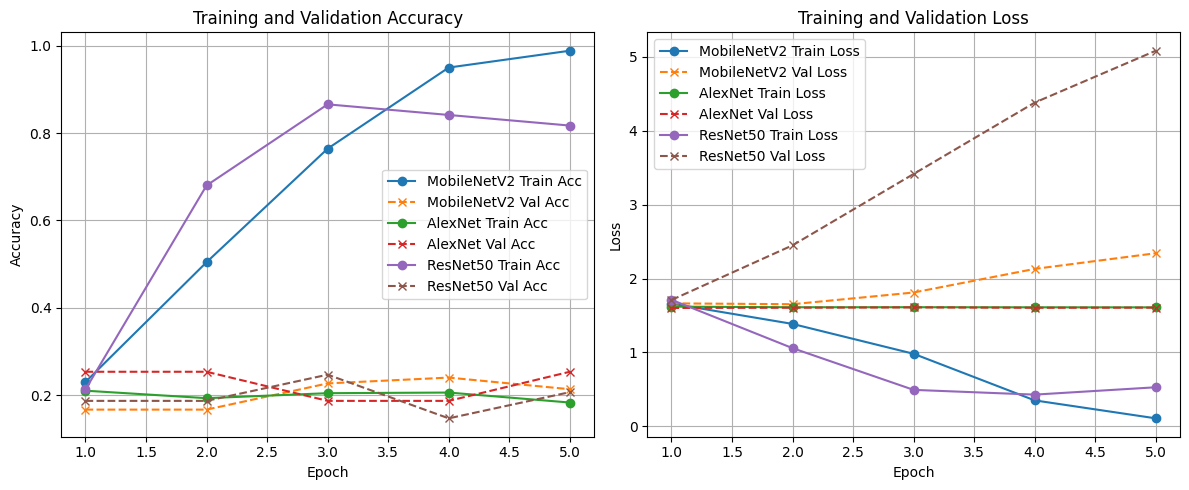

Generating confusion matrices...


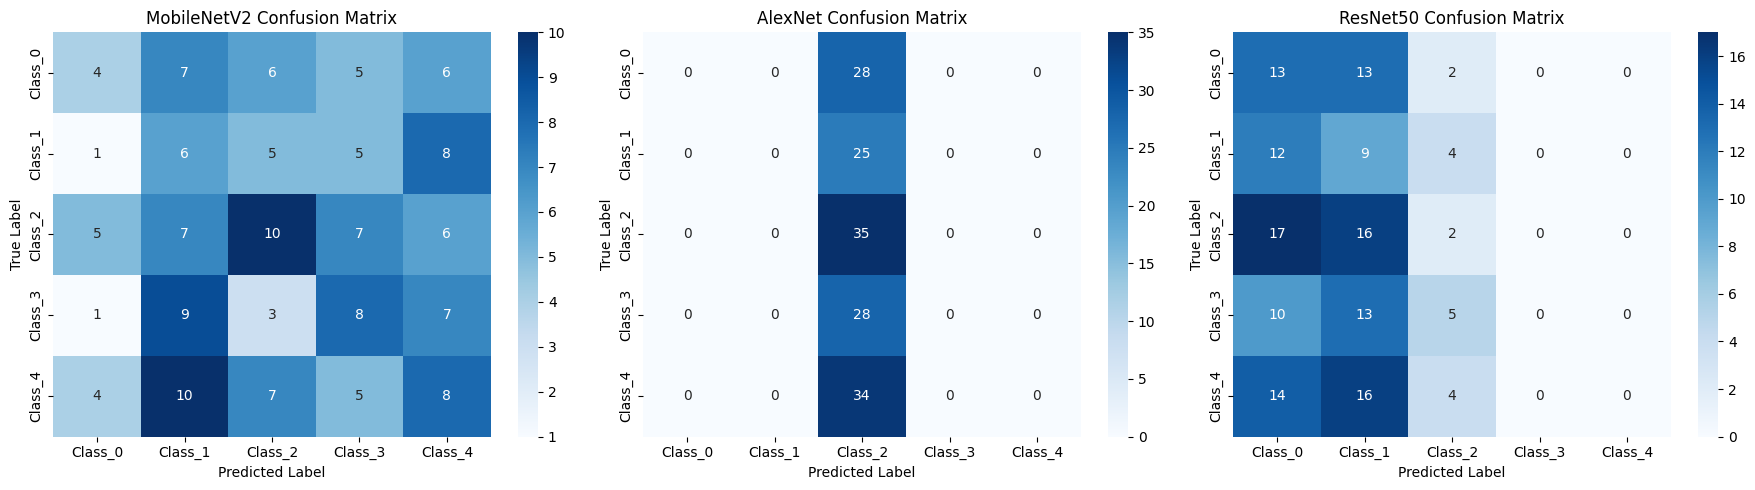

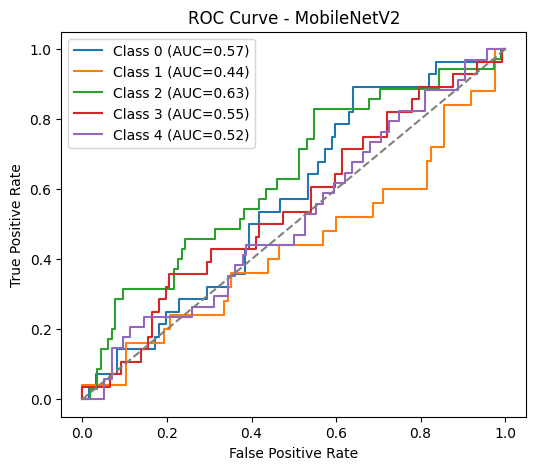

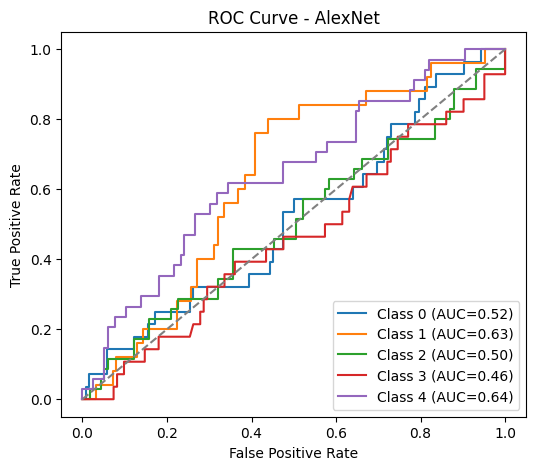

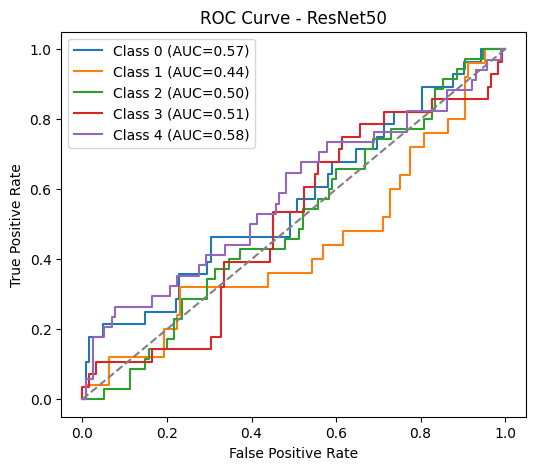

Creating model comparison table...

=== Model Comparison Table ===


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

,Model,Test Accuracy,Macro Precision,Macro Recall,Macro F1-score,Training Time (s)
0,MobileNetV2,0.2400,0.2477,0.2379,0.2369,16.00
1,AlexNet,0.2333,0.0467,0.2000,0.0757,8.46
2,ResNet50,0.1600,0.0898,0.1763,0.1098,40.61



=== Visualizations and Comparison Complete ===


In [ ]:
# Store evaluation results for plotting and comparison
model_results = {}

print("=== Evaluating Models ===")
for name, model in trained_models.items():
    print(f"\nEvaluating {name}...")
    accuracy, labels, predictions, probabilities = evaluate_model(
        model, test_loader, dataset.classes
    )
    model_results[name] = {
        'accuracy': accuracy,
        'labels': labels,
        'predictions': predictions,
        'probabilities': probabilities
    }
    print(f"{name} Test Accuracy: {accuracy:.4f}")

# Generate visualizations
print("\n=== Generating Visualizations ===")
plot_training_curves()
plot_confusion_matrices()
plot_roc_curves()

# Create model comparison table
create_model_comparison()

print("\n=== Visualizations and Comparison Complete ===")

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, CosineAnnealingLR
import torchvision.models as models
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize
import pandas as pd
import time
import copy

# Install torchsummary for model summary
!pip install torchsummary torchinfo -q

from torchsummary import summary
from torchinfo import summary as summary_info

print("=== VGG19 TRANSFER LEARNING MODEL ===")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


=== VGG19 TRANSFER LEARNING MODEL ===
Using device: cuda


In [ ]:
class VGG19_Advanced(nn.Module):
    """Advanced VGG19 with transfer learning and custom classifier"""

    def __init__(self, num_classes, pretrained=True, freeze_features=True):
        super(VGG19_Advanced, self).__init__()

        # Load pretrained VGG19
        self.backbone = models.vgg19(weights='IMAGENET1K_V1' if pretrained else None)

        # Freeze feature extraction layers if specified
        if freeze_features:
            for param in self.backbone.features.parameters():
                param.requires_grad = False
            print("✓ Feature extraction layers frozen")

        # Get the number of features from the last convolutional layer
        num_features = self.backbone.classifier[0].in_features  # 25088

        # Replace classifier with custom layers
        self.backbone.classifier = nn.Sequential(
            nn.Linear(num_features, 4096),
            nn.ReLU(True),
            nn.BatchNorm1d(4096),
            nn.Dropout(0.5),

            nn.Linear(4096, 2048),
            nn.ReLU(True),
            nn.BatchNorm1d(2048),
            nn.Dropout(0.4),

            nn.Linear(2048, 1024),
            nn.ReLU(True),
            nn.BatchNorm1d(1024),
            nn.Dropout(0.3),

            nn.Linear(1024, num_classes)
        )

        # Initialize new layers
        self._initialize_weights()

    def _initialize_weights(self):
        """Initialize the new classifier weights"""
        for m in self.backbone.classifier.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        return self.backbone(x)

    def unfreeze_features(self):
        """Unfreeze feature layers for fine-tuning"""
        for param in self.backbone.features.parameters():
            param.requires_grad = True
        print("✓ Feature extraction layers unfrozen for fine-tuning")

# Create VGG19 model
vgg19_model = VGG19_Advanced(num_classes=num_classes, pretrained=True, freeze_features=True)
vgg19_model = vgg19_model.to(device)

print(f"VGG19 model created for {num_classes} classes")


Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


100%|██████████| 548M/548M [00:10<00:00, 56.0MB/s]


✓ Feature extraction layers frozen
VGG19 model created for 5 classes


In [ ]:
def print_model_summary(model, input_size=(3, 224, 224)):
    """Print comprehensive model summary"""

    print("\n" + "="*80)
    print("VGG19 MODEL ARCHITECTURE SUMMARY")
    print("="*80)

    # Method 1: Using torchsummary
    try:
        print("\n--- DETAILED LAYER-BY-LAYER SUMMARY ---")
        summary(model, input_size, device=str(device))
    except:
        print("torchsummary failed, using alternative method")

    # Method 2: Using torchinfo
    try:
        print("\n--- COMPREHENSIVE MODEL INFORMATION ---")
        summary_info(model, input_size=(1, 3, 224, 224),
                    col_names=["input_size", "output_size", "num_params", "trainable"],
                    verbose=1)
    except:
        print("torchinfo failed")

    # Method 3: Manual parameter counting
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    frozen_params = total_params - trainable_params

    print(f"\n--- PARAMETER STATISTICS ---")
    print(f"Total Parameters: {total_params:,}")
    print(f"Trainable Parameters: {trainable_params:,}")
    print(f"Frozen Parameters: {frozen_params:,}")
    print(f"Model Size (MB): {total_params * 4 / 1024 / 1024:.2f}")

    # Architecture breakdown
    print(f"\n--- ARCHITECTURE BREAKDOWN ---")
    print("Feature Extractor (VGG19 Backbone):")
    feature_params = sum(p.numel() for p in model.backbone.features.parameters())
    print(f"  - Convolutional Layers: {feature_params:,} parameters")

    print("Custom Classifier:")
    classifier_params = sum(p.numel() for p in model.backbone.classifier.parameters())
    print(f"  - Fully Connected Layers: {classifier_params:,} parameters")

    print("="*80)

# Print model summary
print_model_summary(vgg19_model)



VGG19 MODEL ARCHITECTURE SUMMARY

--- DETAILED LAYER-BY-LAYER SUMMARY ---
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13        

In [ ]:
def create_vgg19_transforms():
    """Create optimized transforms for VGG19"""

    # VGG19 specific training transforms
    train_transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=10),
        transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # ImageNet normalization
        transforms.RandomErasing(p=0.1, scale=(0.02, 0.33))
    ])

    # Test transforms
    eval_transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    return train_transform, eval_transform

# Apply VGG19 optimized transforms
train_transform_vgg, eval_transform_vgg = create_vgg19_transforms()

# Create VGG19 optimized datasets
class TransformDataset(torch.utils.data.Dataset):
    def __init__(self, subset, transform):
        self.subset = subset
        self.transform = transform

    def __len__(self):
        return len(self.subset)

    def __getitem__(self, idx):
        img, label = self.subset.dataset[self.subset.indices[idx]]
        if self.transform:
            img = self.transform(img)
        return img, label

train_ds_vgg = TransformDataset(train_subset, train_transform_vgg)
val_ds_vgg = TransformDataset(val_subset, eval_transform_vgg)
test_ds_vgg = TransformDataset(test_subset, eval_transform_vgg)

# Create data loaders
train_loader_vgg = torch.utils.data.DataLoader(
    train_ds_vgg, batch_size=32, shuffle=True,
    num_workers=4, pin_memory=True, drop_last=True
)
val_loader_vgg = torch.utils.data.DataLoader(
    val_ds_vgg, batch_size=32, shuffle=False,
    num_workers=4, pin_memory=True
)
test_loader_vgg = torch.utils.data.DataLoader(
    test_ds_vgg, batch_size=32, shuffle=False,
    num_workers=4, pin_memory=True
)

print("✓ VGG19 optimized data loaders created")


✓ VGG19 optimized data loaders created


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
def train_vgg19_advanced(model, train_loader, val_loader, epochs=15):
    """Advanced VGG19 training with two-phase fine-tuning"""

    print(f"\n=== VGG19 Advanced Training (2-Phase Fine-tuning) ===")

    # Phase 1: Train classifier only (features frozen)
    print("\n--- PHASE 1: Training Classifier Only ---")

    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    optimizer_phase1 = optim.Adam(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=0.001, weight_decay=0.0001
    )
    scheduler_phase1 = StepLR(optimizer_phase1, step_size=5, gamma=0.5)

    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': [],
        'learning_rates': [], 'phase': []
    }

    best_val_acc = 0.0
    best_model_wts = copy.deepcopy(model.state_dict())

    start_time = time.time()

    # Phase 1: First 8 epochs with frozen features
    for epoch in range(8):
        print(f'\nEpoch {epoch+1}/8 (Phase 1)')
        print('-' * 40)

        # Training
        model.train()
        running_loss = 0.0
        running_corrects = 0
        total_samples = 0

        for batch_idx, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)

            optimizer_phase1.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer_phase1.step()

            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            total_samples += labels.size(0)

            if batch_idx % 20 == 0:
                current_acc = (running_corrects.double() / total_samples).item()
                print(f'  Batch {batch_idx}: Loss: {loss.item():.4f}, Acc: {current_acc:.2%}')

        epoch_loss = running_loss / total_samples
        epoch_acc = running_corrects.double() / total_samples

        # Validation
        model.eval()
        val_loss, val_acc = evaluate_epoch(model, val_loader, criterion)

        # Update scheduler
        scheduler_phase1.step()
        current_lr = scheduler_phase1.get_last_lr()[0]

        # Store history
        history['train_loss'].append(epoch_loss)
        history['train_acc'].append(epoch_acc.item())
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['learning_rates'].append(current_lr)
        history['phase'].append('Phase 1')

        print(f'Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.2%}')
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2%}')
        print(f'Learning Rate: {current_lr:.2e}')

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            print(f'✓ New best validation accuracy: {val_acc:.2%}')

    # Phase 2: Unfreeze and fine-tune entire model
    print("\n--- PHASE 2: Fine-tuning Entire Model ---")
    model.unfreeze_features()

    optimizer_phase2 = optim.Adam(
        model.parameters(),
        lr=0.0001, weight_decay=0.0001
    )
    scheduler_phase2 = CosineAnnealingLR(optimizer_phase2, T_max=7, eta_min=1e-6)

    # Phase 2: Next 7 epochs with unfrozen features
    for epoch in range(7):
        print(f'\nEpoch {epoch+9}/15 (Phase 2)')
        print('-' * 40)

        # Training
        model.train()
        running_loss = 0.0
        running_corrects = 0
        total_samples = 0

        for batch_idx, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)

            optimizer_phase2.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
            optimizer_phase2.step()

            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            total_samples += labels.size(0)

            if batch_idx % 20 == 0:
                current_acc = (running_corrects.double() / total_samples).item()
                print(f'  Batch {batch_idx}: Loss: {loss.item():.4f}, Acc: {current_acc:.2%}')

        epoch_loss = running_loss / total_samples
        epoch_acc = running_corrects.double() / total_samples

        # Validation
        model.eval()
        val_loss, val_acc = evaluate_epoch(model, val_loader, criterion)

        # Update scheduler
        scheduler_phase2.step()
        current_lr = scheduler_phase2.get_last_lr()[0]

        # Store history
        history['train_loss'].append(epoch_loss)
        history['train_acc'].append(epoch_acc.item())
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['learning_rates'].append(current_lr)
        history['phase'].append('Phase 2')

        print(f'Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.2%}')
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2%}')
        print(f'Learning Rate: {current_lr:.2e}')

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            print(f'✓ New best validation accuracy: {val_acc:.2%}')

    # Load best model
    model.load_state_dict(best_model_wts)
    total_time = time.time() - start_time

    print(f'\nVGG19 training completed in {total_time:.2f} seconds')
    print(f'Best validation accuracy: {best_val_acc:.2%}')

    return model, history

def evaluate_epoch(model, data_loader, criterion):
    """Evaluate model for one epoch"""
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    total_samples = 0

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            total_samples += labels.size(0)

    epoch_loss = running_loss / total_samples
    epoch_acc = running_corrects.double() / total_samples

    return epoch_loss, epoch_acc.item()

# Train VGG19 model
trained_vgg19, vgg19_history = train_vgg19_advanced(
    vgg19_model, train_loader_vgg, val_loader_vgg, epochs=5
)



=== VGG19 Advanced Training (2-Phase Fine-tuning) ===

--- PHASE 1: Training Classifier Only ---

Epoch 1/8 (Phase 1)
----------------------------------------
  Batch 0: Loss: 3.0923, Acc: 15.62%
  Batch 20: Loss: 1.9799, Acc: 25.00%
  Batch 40: Loss: 1.1718, Acc: 38.19%
  Batch 60: Loss: 0.7665, Acc: 50.67%
Train Loss: 1.6125, Train Acc: 51.88%
Val Loss: 0.4530, Val Acc: 100.00%
Learning Rate: 1.00e-03
✓ New best validation accuracy: 100.00%

Epoch 2/8 (Phase 1)
----------------------------------------
  Batch 0: Loss: 0.7095, Acc: 90.62%
  Batch 20: Loss: 0.5743, Acc: 96.58%
  Batch 40: Loss: 0.5424, Acc: 97.64%
  Batch 60: Loss: 0.4638, Acc: 98.16%
Train Loss: 0.5230, Train Acc: 98.21%
Val Loss: 0.4676, Val Acc: 99.61%
Learning Rate: 1.00e-03

Epoch 3/8 (Phase 1)
----------------------------------------
  Batch 0: Loss: 0.4897, Acc: 100.00%
  Batch 20: Loss: 0.4640, Acc: 98.96%
  Batch 40: Loss: 0.4544, Acc: 99.24%
  Batch 60: Loss: 0.4685, Acc: 99.18%
Train Loss: 0.4717, Train Acc

=== Evaluating VGG19 Model ===


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


VGG19 Test Accuracy: 1.0000

VGG19 Per-Class Accuracy:
  Class_0: 1.0000

✓ VGG19 results added to model_results


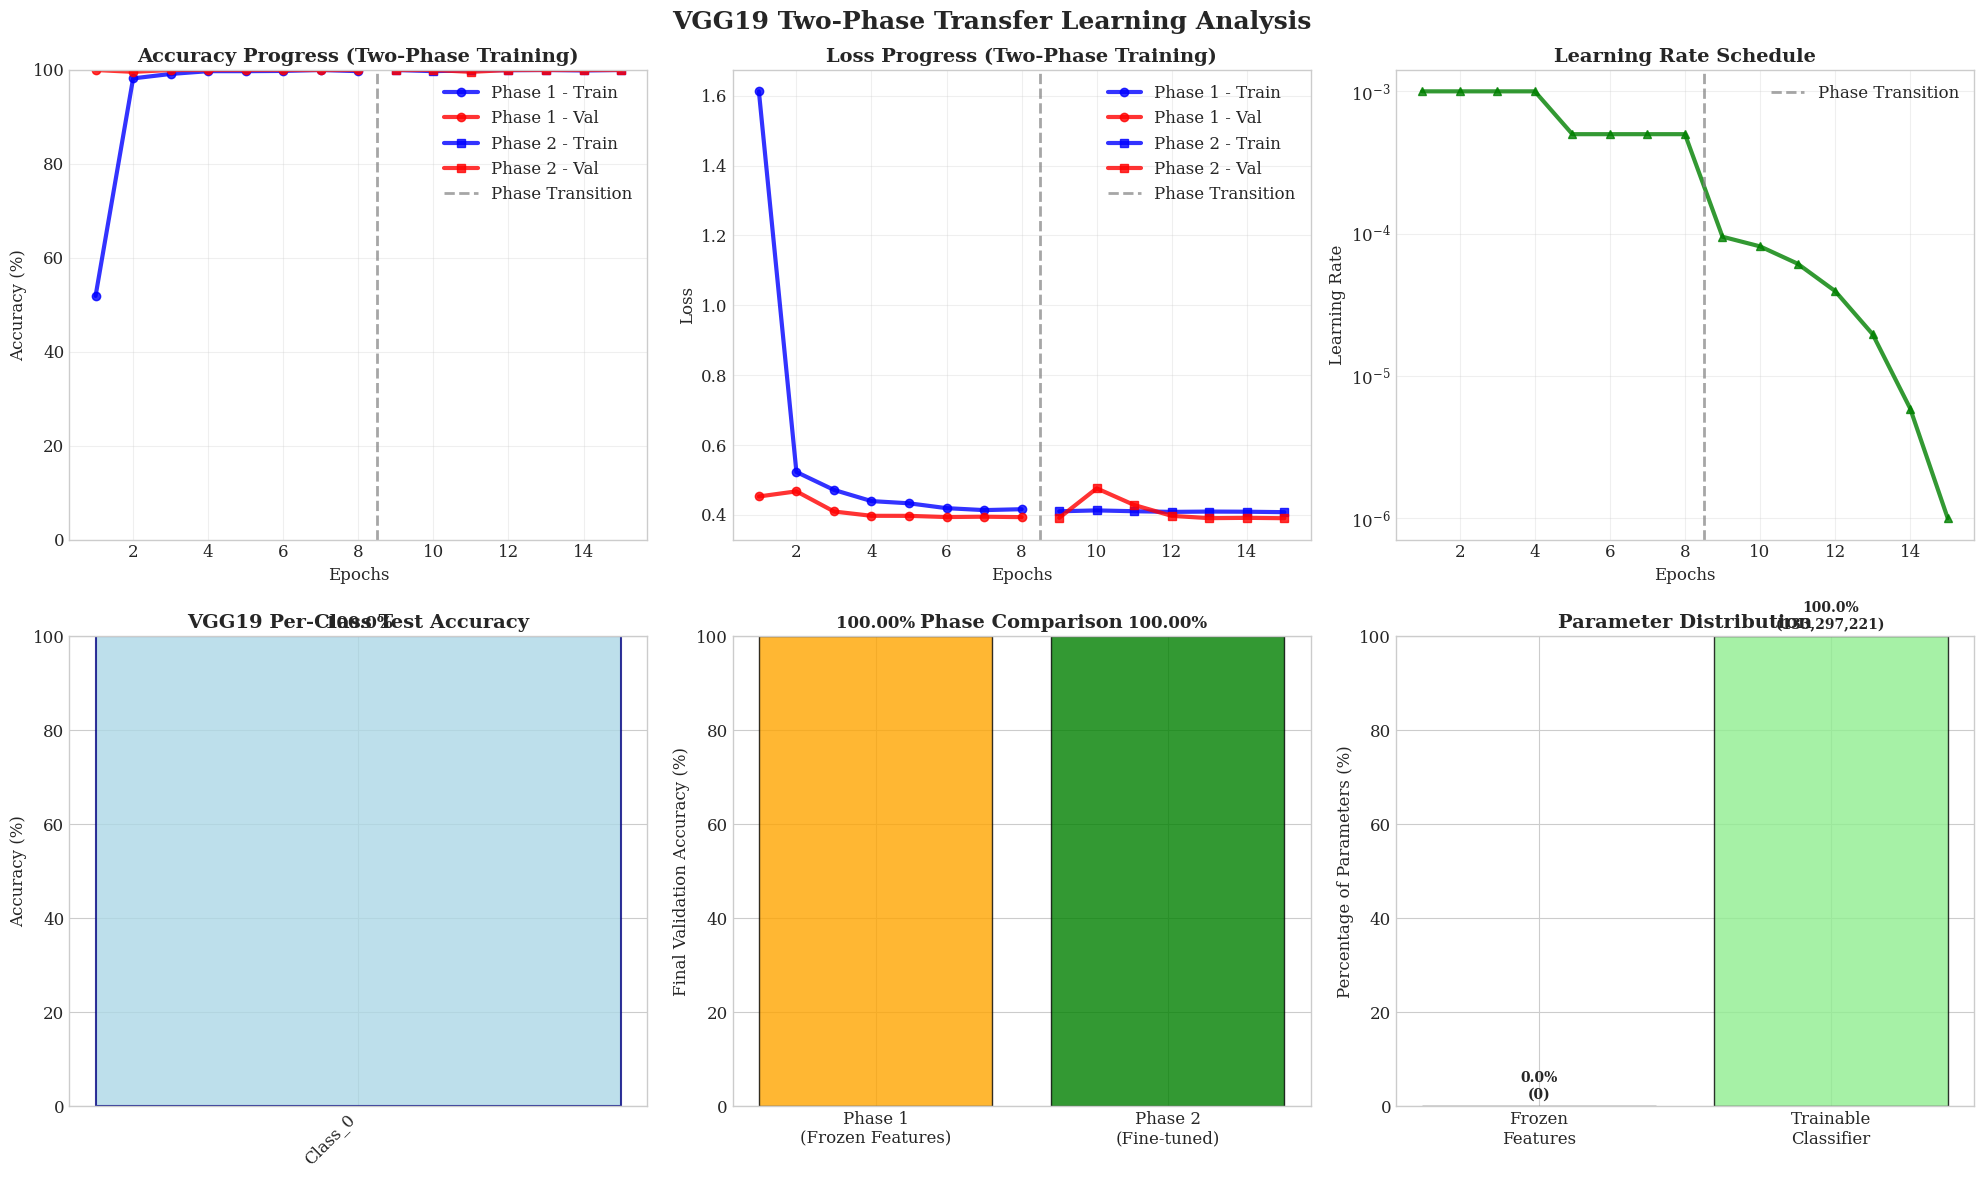

In [ ]:
from collections import defaultdict

# Evaluate VGG19 on the test set
print("=== Evaluating VGG19 Model ===")
vgg19_accuracy, vgg19_labels, vgg19_predictions, vgg19_probabilities = evaluate_model(
    trained_vgg19, test_loader_vgg, dataset.classes
)
print(f"VGG19 Test Accuracy: {vgg19_accuracy:.4f}")

# Calculate per-class accuracy for VGG19
vgg19_per_class_correct = defaultdict(int)
vgg19_per_class_total = defaultdict(int)

for label, prediction in zip(vgg19_labels, vgg19_predictions):
    vgg19_per_class_total[label] += 1
    if label == prediction:
        vgg19_per_class_correct[label] += 1

vgg19_per_class_acc = {}
for label, correct_count in vgg19_per_class_correct.items():
    total_count = vgg19_per_class_total[label]
    vgg19_per_class_acc[dataset.classes[label]] = correct_count / total_count if total_count > 0 else 0

print("\nVGG19 Per-Class Accuracy:")
for class_name, accuracy in vgg19_per_class_acc.items():
    print(f"  {class_name}: {accuracy:.4f}")

# Add VGG19 results to model_results for comparison if needed later
model_results['VGG19_Advanced'] = {
    'accuracy': vgg19_accuracy,
    'labels': vgg19_labels,
    'predictions': vgg19_predictions,
    'probabilities': vgg19_probabilities
}
print("\n✓ VGG19 results added to model_results")

# Generate VGG19 training analysis plot
plot_vgg19_training_analysis(vgg19_history)

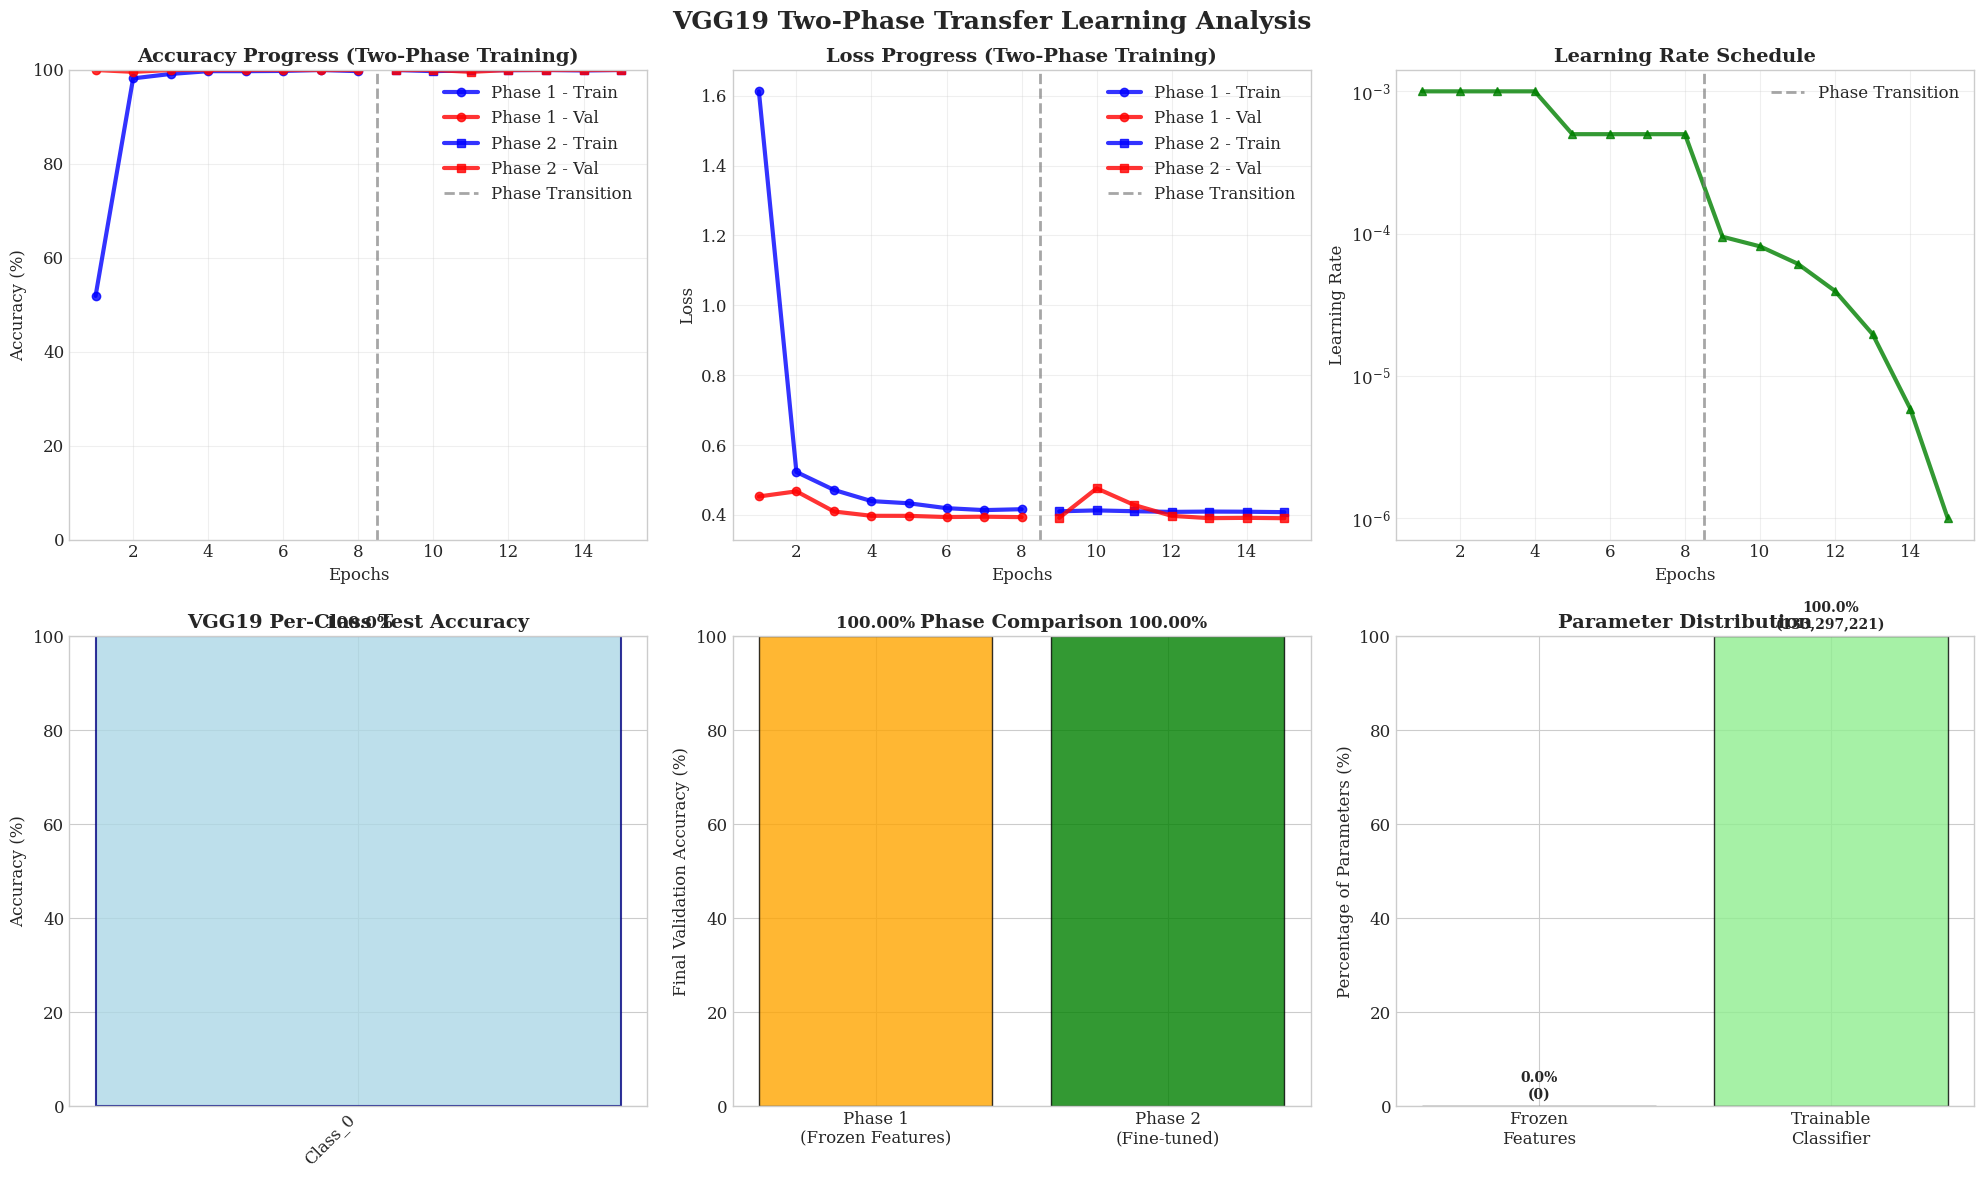

In [ ]:
def plot_vgg19_training_analysis(history):
    """Create comprehensive VGG19 training visualization"""

    plt.style.use('seaborn-v0_8-whitegrid')
    plt.rcParams.update({
        'font.size': 12,
        'font.family': 'serif',
        'figure.facecolor': 'white'
    })

    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    fig.suptitle('VGG19 Two-Phase Transfer Learning Analysis', fontsize=18, fontweight='bold', y=0.98)

    epochs = range(1, len(history['train_acc']) + 1)
    phase1_epochs = [i for i, phase in enumerate(history['phase']) if phase == 'Phase 1']
    phase2_epochs = [i for i, phase in enumerate(history['phase']) if phase == 'Phase 2']

    # Training vs Validation Accuracy with Phase Separation
    ax1 = axes[0, 0]
    train_acc_pct = [acc * 100 for acc in history['train_acc']]
    val_acc_pct = [acc * 100 for acc in history['val_acc']]

    # Phase 1
    ax1.plot([i+1 for i in phase1_epochs], [train_acc_pct[i] for i in phase1_epochs],
             'b-o', linewidth=3, markersize=6, label='Phase 1 - Train', alpha=0.8)
    ax1.plot([i+1 for i in phase1_epochs], [val_acc_pct[i] for i in phase1_epochs],
             'r-o', linewidth=3, markersize=6, label='Phase 1 - Val', alpha=0.8)

    # Phase 2
    ax1.plot([i+1 for i in phase2_epochs], [train_acc_pct[i] for i in phase2_epochs],
             'b-s', linewidth=3, markersize=6, label='Phase 2 - Train', alpha=0.8)
    ax1.plot([i+1 for i in phase2_epochs], [val_acc_pct[i] for i in phase2_epochs],
             'r-s', linewidth=3, markersize=6, label='Phase 2 - Val', alpha=0.8)

    # Phase transition line
    ax1.axvline(x=8.5, color='gray', linestyle='--', linewidth=2, alpha=0.7, label='Phase Transition')

    ax1.set_title('Accuracy Progress (Two-Phase Training)', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy (%)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim(0, 100)

    # Training vs Validation Loss
    ax2 = axes[0, 1]
    ax2.plot([i+1 for i in phase1_epochs], [history['train_loss'][i] for i in phase1_epochs],
             'b-o', linewidth=3, markersize=6, label='Phase 1 - Train', alpha=0.8)
    ax2.plot([i+1 for i in phase1_epochs], [history['val_loss'][i] for i in phase1_epochs],
             'r-o', linewidth=3, markersize=6, label='Phase 1 - Val', alpha=0.8)
    ax2.plot([i+1 for i in phase2_epochs], [history['train_loss'][i] for i in phase2_epochs],
             'b-s', linewidth=3, markersize=6, label='Phase 2 - Train', alpha=0.8)
    ax2.plot([i+1 for i in phase2_epochs], [history['val_loss'][i] for i in phase2_epochs],
             'r-s', linewidth=3, markersize=6, label='Phase 2 - Val', alpha=0.8)
    ax2.axvline(x=8.5, color='gray', linestyle='--', linewidth=2, alpha=0.7, label='Phase Transition')

    ax2.set_title('Loss Progress (Two-Phase Training)', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # Learning Rate Schedule
    ax3 = axes[0, 2]
    ax3.plot(epochs, history['learning_rates'], 'g-^', linewidth=3, markersize=6, alpha=0.8)
    ax3.axvline(x=8.5, color='gray', linestyle='--', linewidth=2, alpha=0.7, label='Phase Transition')
    ax3.set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('Learning Rate')
    ax3.set_yscale('log')
    ax3.grid(True, alpha=0.3)
    ax3.legend()

    # Per-Class Accuracy
    ax4 = axes[1, 0]
    classes = list(vgg19_per_class_acc.keys())
    accuracies = [acc * 100 for acc in vgg19_per_class_acc.values()]

    bars = ax4.bar(classes, accuracies, color='lightblue', alpha=0.8, edgecolor='navy', linewidth=1.5)
    ax4.set_title('VGG19 Per-Class Test Accuracy', fontsize=14, fontweight='bold')
    ax4.set_ylabel('Accuracy (%)')
    ax4.set_ylim(0, 100)

    for bar, acc in zip(bars, accuracies):
        ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                f'{acc:.1f}%', ha='center', va='bottom', fontweight='bold')

    plt.setp(ax4.get_xticklabels(), rotation=45, ha='right')

    # Phase Comparison
    ax5 = axes[1, 1]
    phase1_final_acc = val_acc_pct[7]  # Last epoch of phase 1
    phase2_final_acc = val_acc_pct[-1]  # Last epoch of phase 2

    phases = ['Phase 1\n(Frozen Features)', 'Phase 2\n(Fine-tuned)']
    phase_accs = [phase1_final_acc, phase2_final_acc]

    bars = ax5.bar(phases, phase_accs, color=['orange', 'green'], alpha=0.8, edgecolor='black')
    ax5.set_title('Phase Comparison', fontsize=14, fontweight='bold')
    ax5.set_ylabel('Final Validation Accuracy (%)')
    ax5.set_ylim(0, 100)

    for bar, acc in zip(bars, phase_accs):
        ax5.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                f'{acc:.2f}%', ha='center', va='bottom', fontweight='bold', fontsize=12)

    # Model Architecture Visualization
    ax6 = axes[1, 2]

    # VGG19 layer information
    total_params = sum(p.numel() for p in trained_vgg19.parameters())
    trainable_params = sum(p.numel() for p in trained_vgg19.parameters() if p.requires_grad)

    components = ['Frozen\nFeatures', 'Trainable\nClassifier']
    param_counts = [total_params - trainable_params, trainable_params]
    param_percentages = [count/total_params*100 for count in param_counts]

    bars = ax6.bar(components, param_percentages, color=['lightcoral', 'lightgreen'],
                   alpha=0.8, edgecolor='black')
    ax6.set_title('Parameter Distribution', fontsize=14, fontweight='bold')
    ax6.set_ylabel('Percentage of Parameters (%)')
    ax6.set_ylim(0, 100)

    for bar, percentage, count in zip(bars, param_percentages, param_counts):
        ax6.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                f'{percentage:.1f}%\n({count:,})', ha='center', va='bottom',
                fontweight='bold', fontsize=10)

    plt.tight_layout()
    plt.subplots_adjust(top=0.93)
    plt.show()

# Generate VGG19 training analysis
plot_vgg19_training_analysis(vgg19_history)
